# Analyzing the Evolution of Stock Market Correlations Using Network Visualization

## Project Overview
This project analyzes how stock market correlations evolve over time using network visualization techniques. We track relationships between major companies or industries and how they strengthen or weaken during economic shifts. By using network graphs, we can visualize market dynamics, particularly during financial crises, economic booms, or major global events (e.g., the 2008 crash, COVID-19 pandemic).

## Motivation
Financial markets are interconnected, and correlations between stocks often shift due to economic conditions, investor sentiment, or sector-specific trends. Understanding these shifts can provide insights for investors, policymakers, and economists. We hypothesize that:

- During market crashes, stock correlations increase, as investors react uniformly (panic selling).
- During stable periods, stock correlations diversify, as different industries perform independently.
- Certain industries (e.g., tech, finance) maintain strong correlations, while others (e.g., consumer goods) fluctuate over time.

## Guiding Question
"How do stock correlations change over time, and what patterns emerge during financial downturns versus stable market periods?"


## Setup and Environment
First, let's install the necessary packages if they're not already installed.

In [ ]:
# Install required packages
!pip install numpy pandas matplotlib seaborn yfinance networkx plotly

Now, let's import the necessary libraries for our analysis.

In [ ]:
# Basic data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Financial data
import yfinance as yf

# Network analysis and visualization
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px

# Date handling
from datetime import datetime, timedelta

# Set plotting style
# Use a compatible style for newer matplotlib versions
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib versions
except:
    plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib versions
sns.set_context("talk")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Data Collection
In this section, we'll collect historical stock price data for a set of S&P 500 companies. We'll use the yfinance library to fetch data from Yahoo Finance.

In [ ]:
# Define a function to download stock data
def download_stock_data(tickers, start_date, end_date, interval='1d'):
    """
    Download historical stock data for a list of tickers.

    Parameters:
    -----------
    tickers : list
        List of stock ticker symbols
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    interval : str, default='1d'
        Data interval (1d, 1wk, 1mo, etc.)

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the closing prices for all tickers
    """
    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)

    # Extract close prices (use 'Close' instead of 'Adj Close' as it might not be available in newer versions)
    try:
        # First try to get Adj Close (preferred)
        if len(tickers) == 1:
            prices = data['Adj Close'].to_frame(name=tickers[0])
        else:
            prices = data['Adj Close']
    except KeyError:
        # Fall back to Close if Adj Close is not available
        if len(tickers) == 1:
            prices = data['Close'].to_frame(name=tickers[0])
        else:
            prices = data['Close']
        print("Note: Using 'Close' prices instead of 'Adj Close' as it's not available.")

    return prices

### Define S&P 500 Stocks and Sectors
We'll define a subset of S&P 500 stocks to analyze, grouped by sector. For simplicity, we'll start with a representative sample from major sectors.

In [ ]:
# Define stocks by sector (a representative sample of S&P 500)
stocks_by_sector = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'ADBE', 'CSCO', 'INTC', 'AMD', 'IBM', 'ORCL'],
    'Financial': ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'BLK', 'V', 'MA'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABBV', 'ABT', 'UNH', 'CVS', 'MDT'],
    'Consumer Discretionary': ['AMZN', 'HD', 'NKE', 'SBUX', 'MCD', 'TSLA', 'TGT', 'LOW'],
    'Consumer Staples': ['PG', 'KO', 'PEP', 'WMT', 'COST', 'CL', 'EL', 'GIS'],
    'Energy': ['XOM', 'CVX', 'COP', 'EOG', 'SLB', 'PSX', 'VLO'],
    'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP', 'EXC', 'SRE'],
    'Industrials': ['HON', 'UNP', 'UPS', 'CAT', 'GE', 'MMM', 'BA', 'LMT'],
    'Materials': ['LIN', 'ECL', 'APD', 'DD', 'NEM', 'FCX', 'DOW'],
    'Communication Services': ['GOOGL', 'META', 'NFLX', 'CMCSA', 'VZ', 'T', 'TMUS', 'DIS']  # Updated FB to META
}

# Create a flat list of all tickers
all_tickers = [ticker for sector_tickers in stocks_by_sector.values() for ticker in sector_tickers]

# Create a mapping from ticker to sector
ticker_to_sector = {}
for sector, tickers in stocks_by_sector.items():
    for ticker in tickers:
        ticker_to_sector[ticker] = sector

print(f"Total number of stocks: {len(all_tickers)}")
print(f"Number of sectors: {len(stocks_by_sector)}")

Total number of stocks: 80
Number of sectors: 10


### Download Historical Stock Data
Now, let's download historical stock data for our selected companies. We'll focus on a period that includes significant market events like the 2008 financial crisis and the COVID-19 pandemic.

In [ ]:
# Define the time period
start_date = '2006-01-01'  # Before the 2008 financial crisis
end_date = '2023-01-01'    # After the COVID-19 pandemic

# Download the data
print(f"Downloading stock data from {start_date} to {end_date}...")
stock_data = download_stock_data(all_tickers, start_date, end_date)

# Display the first few rows
stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  80 of 80 completed

Note: Using 'Close' prices instead of 'Adj Close' as it's not available.


Ticker          AAPL  ABBV        ABT       ADBE        AEP        AMD  \
Date                                                                     
2006-01-03  2.249496   NaN  12.153678  38.520000  17.434832  32.400002   
2006-01-04  2.256117   NaN  12.172115  38.419998  17.406834  32.560001   
2006-01-05  2.238362   NaN  12.328847  38.070000  17.308826  33.680000   
2006-01-06  2.296142   NaN  12.565465  39.000000  17.579500  33.779999   
2006-01-09  2.288618   NaN  13.032562  38.380001  17.318167  33.250000   

Ticker        AMZN        APD        AXP         BA        BAC        BLK  \
Date                                                                        
2006-01-03  2.3790  34.439690  39.269142  50.119690  31.173676  68.705635   
2006-01-04  2.3625  34.046818  38.887383  50.639088  30.842604  68.819054   
2006-01-05  2.3825  33.752151  39.299068  50.041435  30.882345  68.075294   
2006-01-06  2.3935  34.537891  39.433815  49.344139  30.835968  69.600677   
2006-01-09  2.3540  34.098801  40.414433  48.931446  30.855839  70.407486   

Ticker               C        CAT         CL     CMCSA        COP       COST  \
Date                                                                           
2006-01-03  324.013153  35.372658  17.534048  6.121793  24.245600  34.060074   
2006-01-04  318.031128  36.272263  17.741606  6.156799  24.041252  34.169254   
2006-01-05  319.608795  36.272263  17.476555  6.166135  23.852924  33.964565   
2006-01-06  319.608795  36.994411  17.505306  6.366847  24.397846  34.012310   
2006-01-09  318.096954  37.667591  17.712862  6.406525  24.393843  34.148785   

Ticker           CSCO        CVS        CVX          D         DD        DIS  \
Date                                                                           
2006-01-03  11.488684  17.996075  28.369442  17.989731  35.539185  19.777199   
2006-01-04  11.752034  17.996075  28.287819  18.037445  35.134670  19.444878   
2006-01-05  12.081220  18.433167  27.942089  17.610207  36.056931  19.785303   
2006-01-06  12.357741  18.535616  28.451080  17.785200  36.348167  20.052782   
2006-01-09  12.548668  18.405844  28.307030  17.742018  36.040749  20.263521   

Ticker      DOW        DUK        ECL         EL        EOG        EXC  \
Date                                                                     
2006-01-03  NaN  20.337866  28.570599  13.135921  28.204834  18.811918   
2006-01-04  NaN  20.315950  28.306499  13.789953  28.233414  18.811918   
2006-01-05  NaN  20.169851  28.546602  13.545681  27.172642  18.732716   
2006-01-06  NaN  20.301348  28.850710  13.494457  27.786955  19.104673   
2006-01-09  NaN  20.345173  28.698668  13.644179  27.915535  19.056459   

Ticker            FCX          GE        GIS      GOOGL         GS         HD  \
Date                                                                            
2006-01-03  18.278088  104.787621  13.423223  10.839817  95.293106  25.466267   
2006-01-04  19.336334  104.639465  13.534222  11.089126  93.976883  24.996946   
2006-01-05  18.705278  104.372864  13.461122  11.238562  93.939919  24.749939   
2006-01-06  19.106558  105.083862  13.556536  11.597705  95.270920  24.935196   
2006-01-09  18.960932  104.817230  13.559254  11.628589  96.417068  25.206909   

Ticker            HON        IBM       INTC        JNJ        JPM         KO  \
Date                                                                           
2006-01-03  23.141676  43.143185  14.977074  35.278324  24.241714  11.375055   
2006-01-04  23.049009  43.085354  15.176215  35.822117  24.101801  11.352802   
2006-01-05  23.036659  43.374504  15.387087  35.673283  24.174810  11.408424   
2006-01-06  23.394966  44.662621  15.410506  35.833557  24.345133  11.516892   
2006-01-09  23.203451  44.021210  15.504225  36.056812  24.740543  11.572513   

Ticker            LIN        LMT        LOW  MA        MCD        MDT  META  \
Date                                                                          
2006-01-03  3

Stocks with missing values:
Ticker
ABBV    1761
DOW     3324
MA        99
META    1606
PSX     1580
TMUS     324
TSLA    1129
V        555
dtype: int64

Basic statistics:
Ticker         AAPL         ABBV          ABT         ADBE          AEP  \
count   4279.000000  2518.000000  4279.000000  4279.000000  4279.000000   
mean      38.257233    64.178761    43.630249   150.604071    41.721232   
std       45.578628    31.536857    31.890345   164.636128    22.509303   
min        1.524843    20.566854    12.153678    15.980000    12.885365   
25%        7.128121    40.072260    18.275248    34.934999    21.831125   
50%       20.877609    58.790102    32.261555    68.059998    36.120724   
75%       44.191122    78.539688    61.084064   249.245003    58.396557   
max      178.879913   156.298523   133.030029   688.369995    95.313560   

Ticker          AMD         AMZN          APD          AXP           BA  \
count   4279.000000  4279.000000  4279.000000  4279.000000  4279.000000   
mea

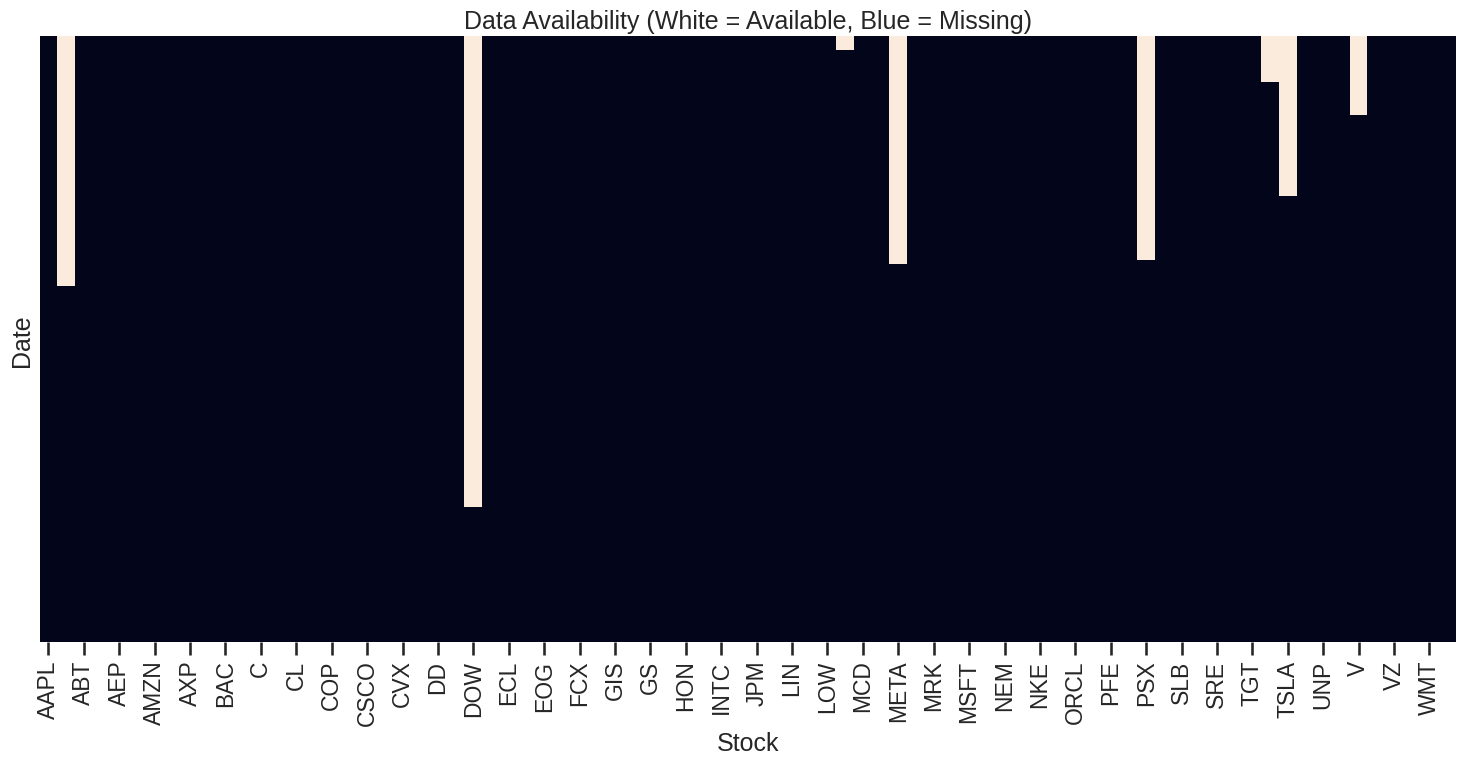

In [ ]:
# Check for missing values
missing_values = stock_data.isnull().sum()
print("Stocks with missing values:")
print(missing_values[missing_values > 0])

# Basic statistics
print("\nBasic statistics:")
print(stock_data.describe())

# Plot the data availability
plt.figure(figsize=(15, 8))
sns.heatmap(stock_data.isnull(), cbar=False, yticklabels=False)
plt.title('Data Availability (White = Available, Blue = Missing)')
plt.xlabel('Stock')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

## Data Processing and Correlation Analysis
Now that we have our stock data, we need to process it and calculate correlations between stocks. We'll handle missing values and calculate correlations for different time periods.

In [ ]:
# Handle missing values by forward filling and then backward filling
stock_data_filled = stock_data.fillna(method='ffill').fillna(method='bfill')

# Calculate daily returns
stock_returns = stock_data_filled.pct_change().dropna()

# Display the first few rows of returns
stock_returns.head()

Ticker          AAPL  ABBV       ABT      ADBE       AEP       AMD      AMZN  \
Date                                                                           
2006-01-04  0.002943   0.0  0.001517 -0.002596 -0.001606  0.004938 -0.006936   
2006-01-05 -0.007870   0.0  0.012876 -0.009110 -0.005630  0.034398  0.008466   
2006-01-06  0.025814   0.0  0.019192  0.024429  0.015638  0.002969  0.004617   
2006-01-09 -0.003277   0.0  0.037173 -0.015897 -0.014866 -0.015690 -0.016503   
2006-01-10  0.063248   0.0 -0.009668  0.005993  0.000269  0.050526 -0.030374   

Ticker           APD       AXP        BA       BAC       BLK         C  \
Date                                                                     
2006-01-04 -0.011408 -0.009722  0.010363 -0.010620  0.001651 -0.018462   
2006-01-05 -0.008655  0.010587 -0.011802  0.001289 -0.010807  0.004961   
2006-01-06  0.023280  0.003429 -0.013934 -0.001502  0.022407  0.000000   
2006-01-09 -0.012713  0.024867 -0.008364  0.000644  0.011592 -0.004730   
2006-01-10 -0.011521 -0.002964  0.004799 -0.008369  0.004118  0.003100   

Ticker           CAT        CL     CMCSA       COP      COST      CSCO  \
Date                                                                     
2006-01-04  0.025432  0.011837  0.005718 -0.008428  0.003206  0.022923   
2006-01-05  0.000000 -0.014940  0.001516 -0.007834 -0.005990  0.028011   
2006-01-06  0.019909  0.001645  0.032551  0.022845  0.001406  0.022889   
2006-01-09  0.018197  0.011857  0.006232 -0.000164  0.004013  0.015450   
2006-01-10 -0.004062 -0.010095 -0.001457 -0.001971 -0.000999 -0.004721   

Ticker           CVS       CVX         D        DD       DIS  DOW       DUK  \
Date                                                                          
2006-01-04  0.000000 -0.002877  0.002652 -0.011382 -0.016803  0.0 -0.001078   
2006-01-05  0.024288 -0.012222 -0.023686  0.026249  0.017507  0.0 -0.007191   
2006-01-06  0.005558  0.018216  0.009937  0.008077  0.013519  0.0  0.006519   
2006-01-09 -0.007001 -0.005063 -0.002428 -0.008458  0.010509  0.0  0.002159   
2006-01-10  0.007051  0.004919  0.008838  0.000673  0.012800  0.0  0.003232   

Ticker           ECL        EL       EOG       EXC       FCX        GE  \
Date                                                                     
2006-01-04 -0.009244  0.049790  0.001013  0.000000  0.057897 -0.001414   
2006-01-05  0.008482 -0.017714 -0.037572 -0.004210 -0.032636 -0.002548   
2006-01-06  0.010653 -0.003782  0.022608  0.019856  0.021453  0.006812   
2006-01-09 -0.005270  0.011095  0.004627 -0.002524 -0.007622 -0.002537   
2006-01-10 -0.008366  0.006642 -0.002047 -0.006868  0.040109 -0.005370   

Ticker           GIS     GOOGL        GS        HD       HON       IBM  \
Date                                                                     
2006-01-04  0.008269  0.022999 -0.013812 -0.018429 -0.004004 -0.001340   
2006-01-05 -0.005401  0.013476 -0.000393 -0.009882 -0.000536  0.006711   
2006-01-06  0.007088  0.031956  0.014169  0.007485  0.015554  0.029698   
2006-01-09  0.000200  0.002663  0.012030  0.010897 -0.008186 -0.014361   
2006-01-10  0.002413  0.006126  0.012578  0.024008 -0.001598  0.004060   

Ticker          INTC       JNJ       JPM        KO       LIN       LMT  \
Date                                                                     
2006-01-04  0.013296  0.015414 -0.005772 -0.001956 -0.007988  0.014634   
2006-01-05  0.013895 -0.004155  0.003029  0.004899 -0.002809  0.000621   
2006-01-06  0.001522  0.004493  0.007045  0.009508  0.021596  0.014724   
2006-01-09  0.006081  0.006230  0.016242  0.004829 -0.018382  0.006567   
2006-01-10 -0.013222  0.001746  0.001475  0.000962 -0.022472  0.000607   

Ticker           LOW   MA       MCD       MDT  META       MMM       MRK  \
Date                                                                      
2006-01-04 -0.012375  0.0  0.008950  0.010667   0.0 -0.005056  0.011603   
2006-01-05 -0.011624  0.0  0.001183 -0.011479   0.0 -0.009148  0.

### Calculate Correlation Matrix
Let's calculate the correlation matrix for the entire period first to get a baseline understanding of stock relationships.

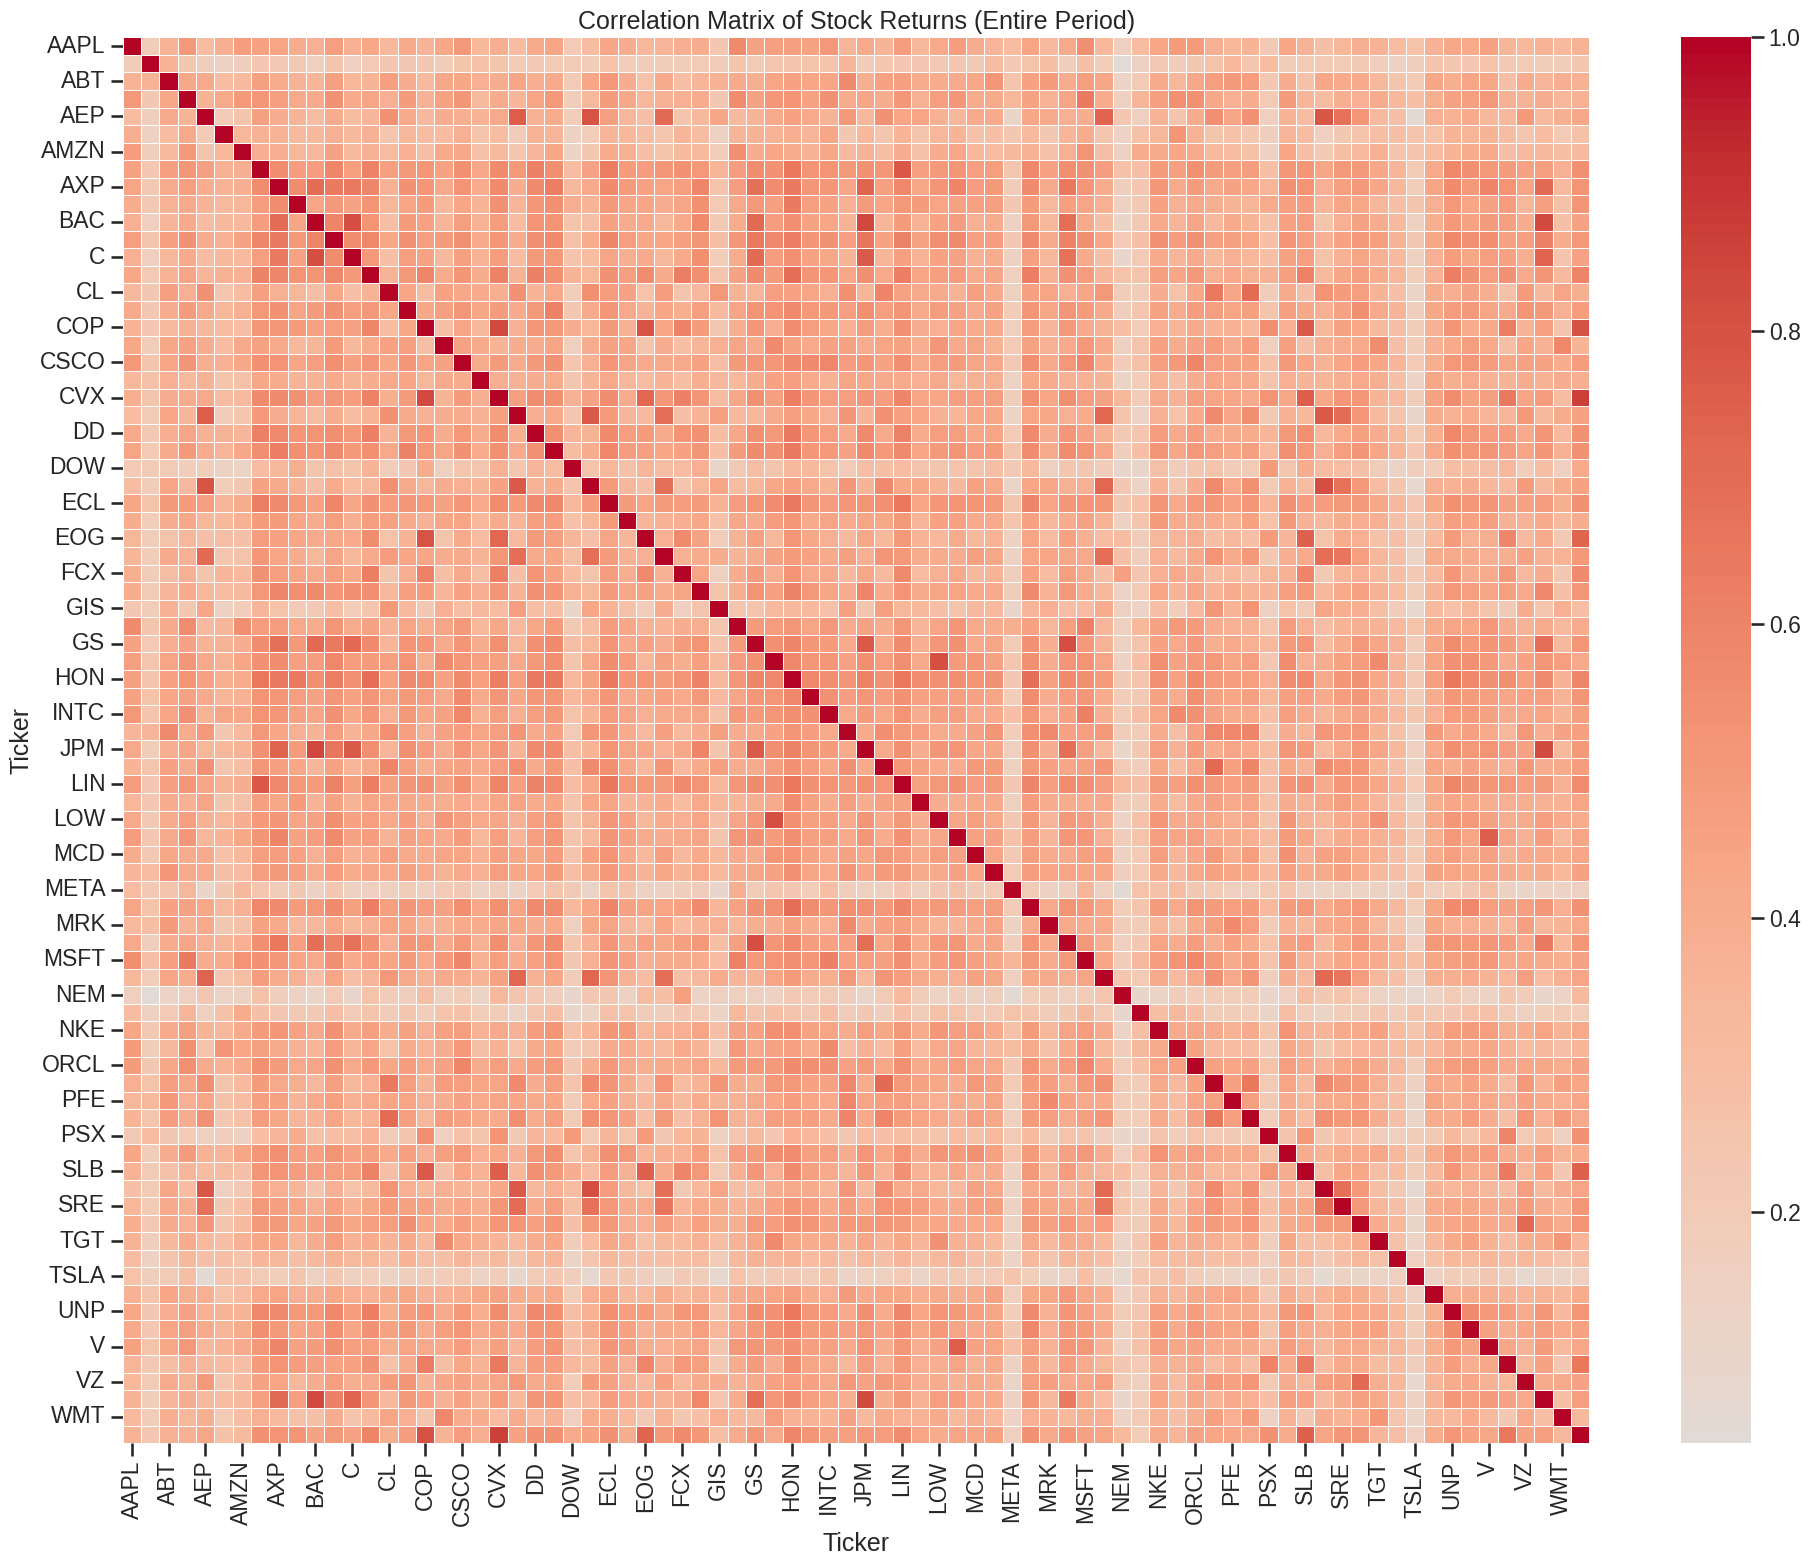

In [ ]:
# Calculate correlation matrix for the entire period
correlation_matrix = stock_returns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Stock Returns (Entire Period)')
plt.tight_layout()
plt.show()

### Correlation Analysis by Sector
Let's analyze correlations within and between sectors to understand industry relationships.

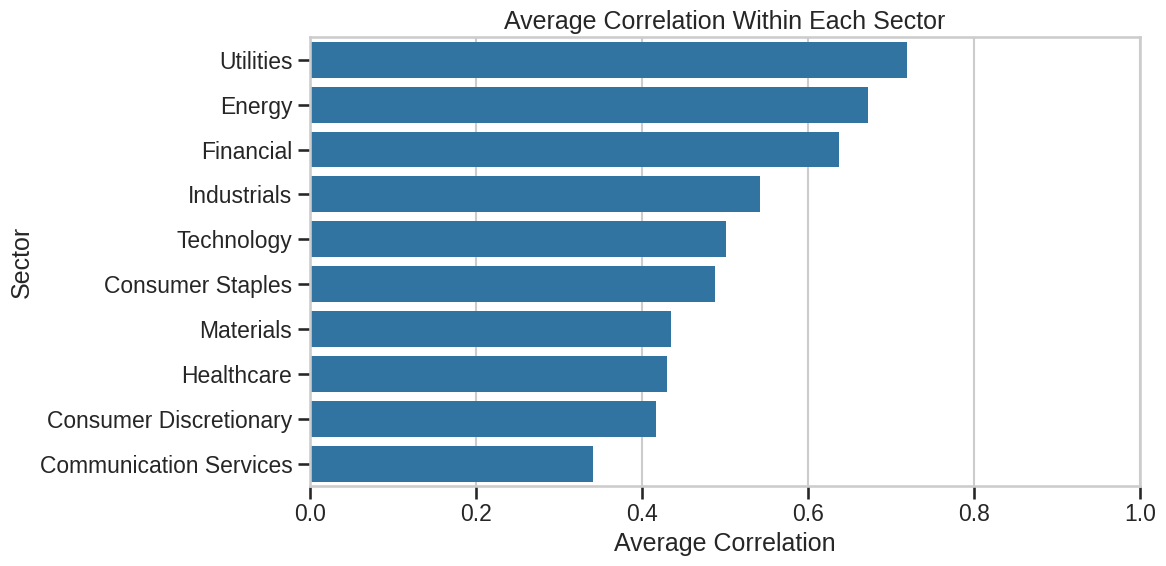

In [ ]:
# Create a DataFrame with sector information
sectors = pd.Series(ticker_to_sector)

# Calculate average correlation within each sector
sector_correlations = {}
for sector, tickers in stocks_by_sector.items():
    # Get correlation matrix for this sector
    sector_corr = correlation_matrix.loc[tickers, tickers]

    # Calculate average correlation (excluding self-correlations)
    mask = ~np.eye(sector_corr.shape[0], dtype=bool)  # Mask to exclude diagonal
    avg_corr = sector_corr.values[mask].mean()

    sector_correlations[sector] = avg_corr

# Convert to DataFrame for visualization
sector_corr_df = pd.DataFrame(list(sector_correlations.items()), columns=['Sector', 'Average Correlation'])
sector_corr_df = sector_corr_df.sort_values('Average Correlation', ascending=False)

# Plot average correlations by sector
plt.figure(figsize=(12, 6))
sns.barplot(x='Average Correlation', y='Sector', data=sector_corr_df)
plt.title('Average Correlation Within Each Sector')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Time-Window Correlation Analysis
Now, let's analyze how correlations change over time by calculating correlation matrices for different time periods. We'll define functions to calculate rolling correlations and visualize them.

In [ ]:
def calculate_rolling_correlations(returns, window=252):
    """
    Calculate rolling correlations for all pairs of stocks.

    Parameters:
    -----------
    returns : pandas.DataFrame
        DataFrame of stock returns
    window : int, default=252
        Rolling window size (252 trading days ≈ 1 year)

    Returns:
    --------
    dict
        Dictionary with (stock1, stock2) tuples as keys and rolling correlation Series as values
    """
    rolling_correlations = {}
    stocks = returns.columns

    # Calculate rolling correlations for each pair of stocks
    for i, stock1 in enumerate(stocks):
        for stock2 in stocks[i+1:]:  # Only calculate each pair once
            # Calculate rolling correlation
            rolling_corr = returns[stock1].rolling(window=window).corr(returns[stock2])
            rolling_correlations[(stock1, stock2)] = rolling_corr

    return rolling_correlations

# Calculate rolling correlations with a 1-year window
print("Calculating rolling correlations (this may take a while)...")
rolling_correlations = calculate_rolling_correlations(stock_returns, window=252)
print(f"Calculated rolling correlations for {len(rolling_correlations)} stock pairs.")

Calculating rolling correlations (this may take a while)...
Calculated rolling correlations for 3160 stock pairs.


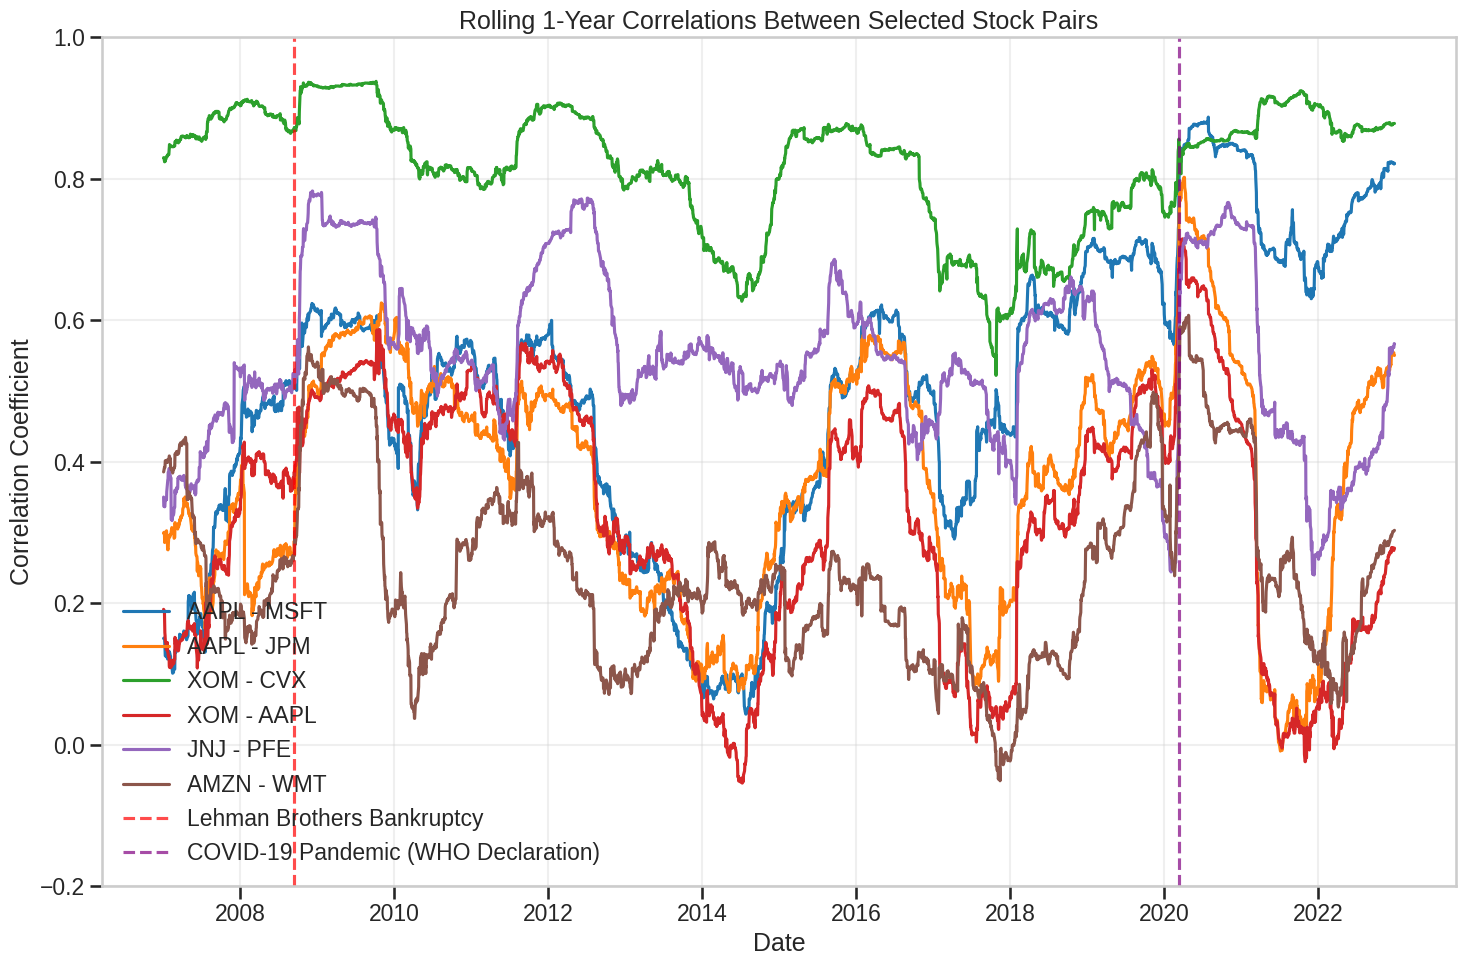

In [ ]:
# Visualize rolling correlations for a few selected pairs
# Select some interesting pairs from different sectors
selected_pairs = [
    ('AAPL', 'MSFT'),  # Tech & Tech
    ('AAPL', 'JPM'),   # Tech & Finance
    ('XOM', 'CVX'),    # Energy & Energy
    ('XOM', 'AAPL'),   # Energy & Tech
    ('JNJ', 'PFE'),    # Healthcare & Healthcare
    ('AMZN', 'WMT')    # Consumer Discretionary & Consumer Staples
]

# Plot rolling correlations for selected pairs
plt.figure(figsize=(15, 10))
for pair in selected_pairs:
    if pair in rolling_correlations:
        plt.plot(rolling_correlations[pair].index, rolling_correlations[pair].values, label=f'{pair[0]} - {pair[1]}')
    else:  # Check if the pair is in reverse order
        reverse_pair = (pair[1], pair[0])
        if reverse_pair in rolling_correlations:
            plt.plot(rolling_correlations[reverse_pair].index, rolling_correlations[reverse_pair].values, label=f'{pair[0]} - {pair[1]}')

# Add vertical lines for major market events
plt.axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', alpha=0.7, label='Lehman Brothers Bankruptcy')
plt.axvline(pd.Timestamp('2020-03-11'), color='purple', linestyle='--', alpha=0.7, label='COVID-19 Pandemic (WHO Declaration)')

plt.title('Rolling 1-Year Correlations Between Selected Stock Pairs')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(-0.2, 1.0)
plt.tight_layout()
plt.show()

## Network Construction
Now, let's construct network graphs from our correlation matrices. We'll create networks for different time periods and visualize how they evolve over time.

In [ ]:
def create_correlation_network(correlation_matrix, threshold=0.5):
    """
    Create a network graph from a correlation matrix.

    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        Correlation matrix
    threshold : float, default=0.5
        Correlation threshold for creating edges

    Returns:
    --------
    networkx.Graph
        Network graph
    """
    # Create an empty graph
    G = nx.Graph()

    # Add nodes (stocks)
    for stock in correlation_matrix.columns:
        G.add_node(stock, sector=ticker_to_sector.get(stock, 'Unknown'))

    # Add edges (correlations above threshold)
    for i, stock1 in enumerate(correlation_matrix.columns):
        for j, stock2 in enumerate(correlation_matrix.columns):
            if i < j:  # Only process each pair once
                correlation = correlation_matrix.loc[stock1, stock2]
                if correlation >= threshold:
                    G.add_edge(stock1, stock2, weight=correlation)

    return G

### Create Networks for Different Time Periods
Let's create networks for different time periods to see how they evolve. We'll focus on periods before, during, and after major market events.

In [ ]:
# Define time periods of interest
time_periods = {
    'Pre-2008 Crisis': ('2006-01-01', '2008-08-31'),
    '2008 Financial Crisis': ('2008-09-01', '2009-03-31'),
    'Post-2008 Recovery': ('2009-04-01', '2010-12-31'),
    'Pre-COVID': ('2019-01-01', '2020-02-29'),
    'COVID Crisis': ('2020-03-01', '2020-08-31'),
    'Post-COVID Recovery': ('2020-09-01', '2022-12-31')
}

# Create networks for each time period
networks = {}
for period_name, (start_date, end_date) in time_periods.items():
    # Filter returns for this period
    period_returns = stock_returns[start_date:end_date]

    # Calculate correlation matrix
    period_corr = period_returns.corr()

    # Create network
    network = create_correlation_network(period_corr, threshold=0.7)  # Higher threshold for clearer visualization
    networks[period_name] = network

    print(f"Period: {period_name}")
    print(f"  - Number of nodes: {network.number_of_nodes()}")
    print(f"  - Number of edges: {network.number_of_edges()}")
    print(f"  - Network density: {nx.density(network):.4f}")

Period: Pre-2008 Crisis
  - Number of nodes: 80
  - Number of edges: 24
  - Network density: 0.0076
Period: 2008 Financial Crisis
  - Number of nodes: 80
  - Number of edges: 537
  - Network density: 0.1699
Period: Post-2008 Recovery
  - Number of nodes: 80
  - Number of edges: 28
  - Network density: 0.0089
Period: Pre-COVID
  - Number of nodes: 80
  - Number of edges: 33
  - Network density: 0.0104
Period: COVID Crisis
  - Number of nodes: 80
  - Number of edges: 1095
  - Network density: 0.3465
Period: Post-COVID Recovery
  - Number of nodes: 80
  - Number of edges: 64
  - Network density: 0.0203


## Network Visualization
Now, let's visualize the networks we've created. We'll use different colors for different sectors and edge weights for correlation strength.

In [ ]:
def visualize_network(G, title, layout=None, figsize=(12, 12)):
    """
    Visualize a network graph.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph
    title : str
        Plot title
    layout : dict, optional
        Node positions for the layout
    figsize : tuple, default=(12, 12)
        Figure size
    """
    plt.figure(figsize=figsize)

    # Create layout if not provided
    if layout is None:
        layout = nx.spring_layout(G, seed=42)

    # Define colors for sectors
    sector_colors = {
        'Technology': 'tab:blue',
        'Financial': 'tab:orange',
        'Healthcare': 'tab:green',
        'Consumer Discretionary': 'tab:red',
        'Consumer Staples': 'tab:purple',
        'Energy': 'tab:brown',
        'Utilities': 'tab:pink',
        'Industrials': 'tab:gray',
        'Materials': 'tab:olive',
        'Communication Services': 'tab:cyan',
        'Unknown': 'black'
    }

    # Get node colors based on sector
    node_colors = [sector_colors[G.nodes[node]['sector']] for node in G.nodes()]

    # Get edge weights
    edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]

    # Draw the network
    nx.draw_networkx_nodes(G, layout, node_size=300, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, layout, width=edge_weights, alpha=0.5)
    nx.draw_networkx_labels(G, layout, font_size=8)

    # Add a legend for sectors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sector)
                      for sector, color in sector_colors.items() if sector in [G.nodes[node]['sector'] for node in G.nodes()]]
    plt.legend(handles=legend_elements, loc='upper right', title='Sectors')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

    return layout  # Return layout for consistent positioning across plots

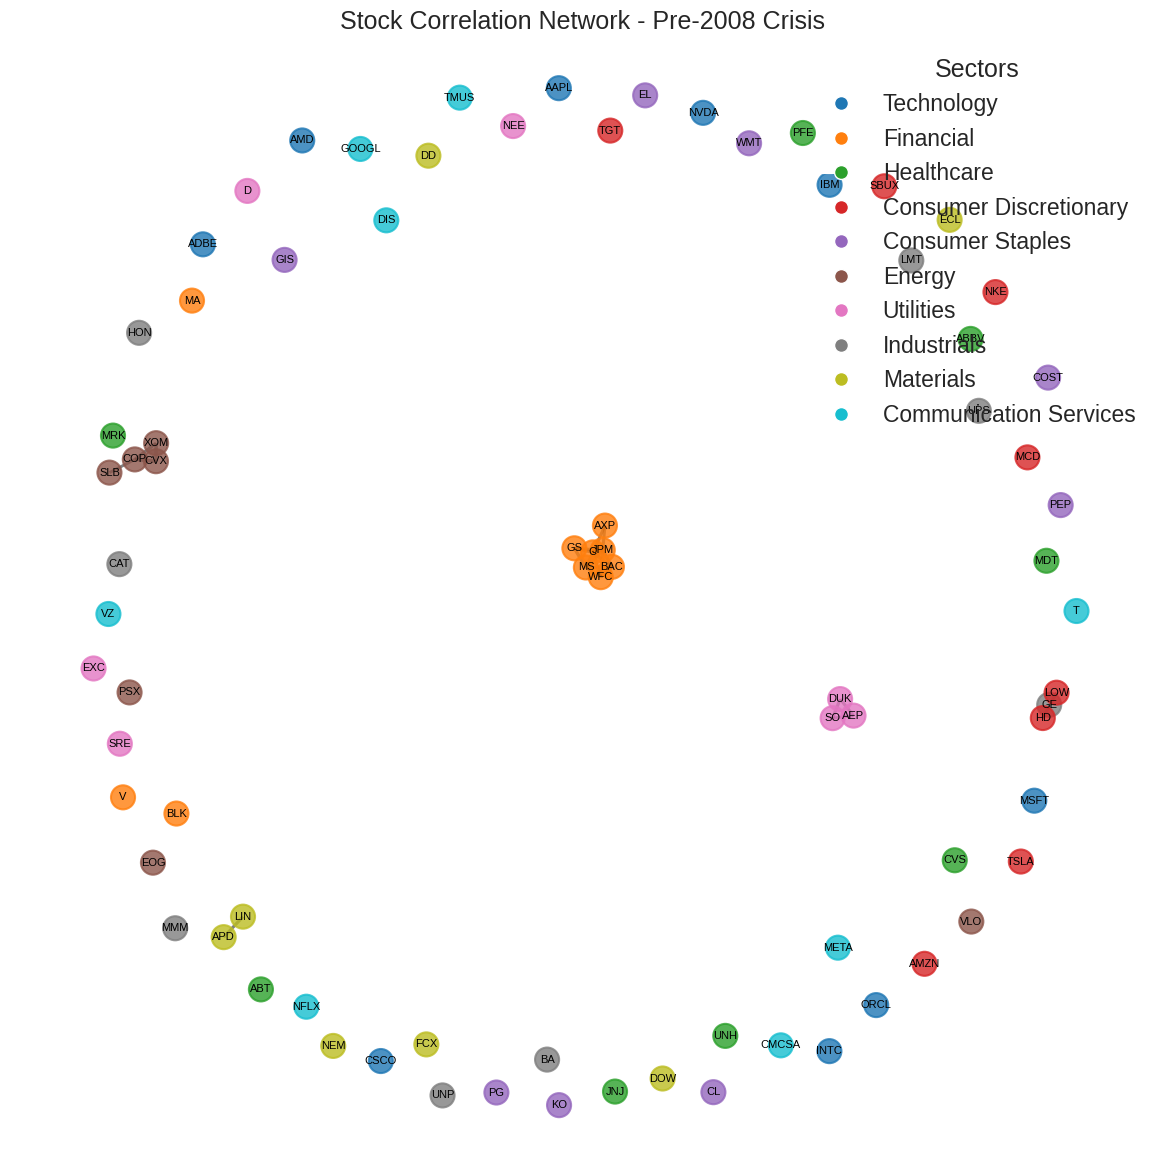

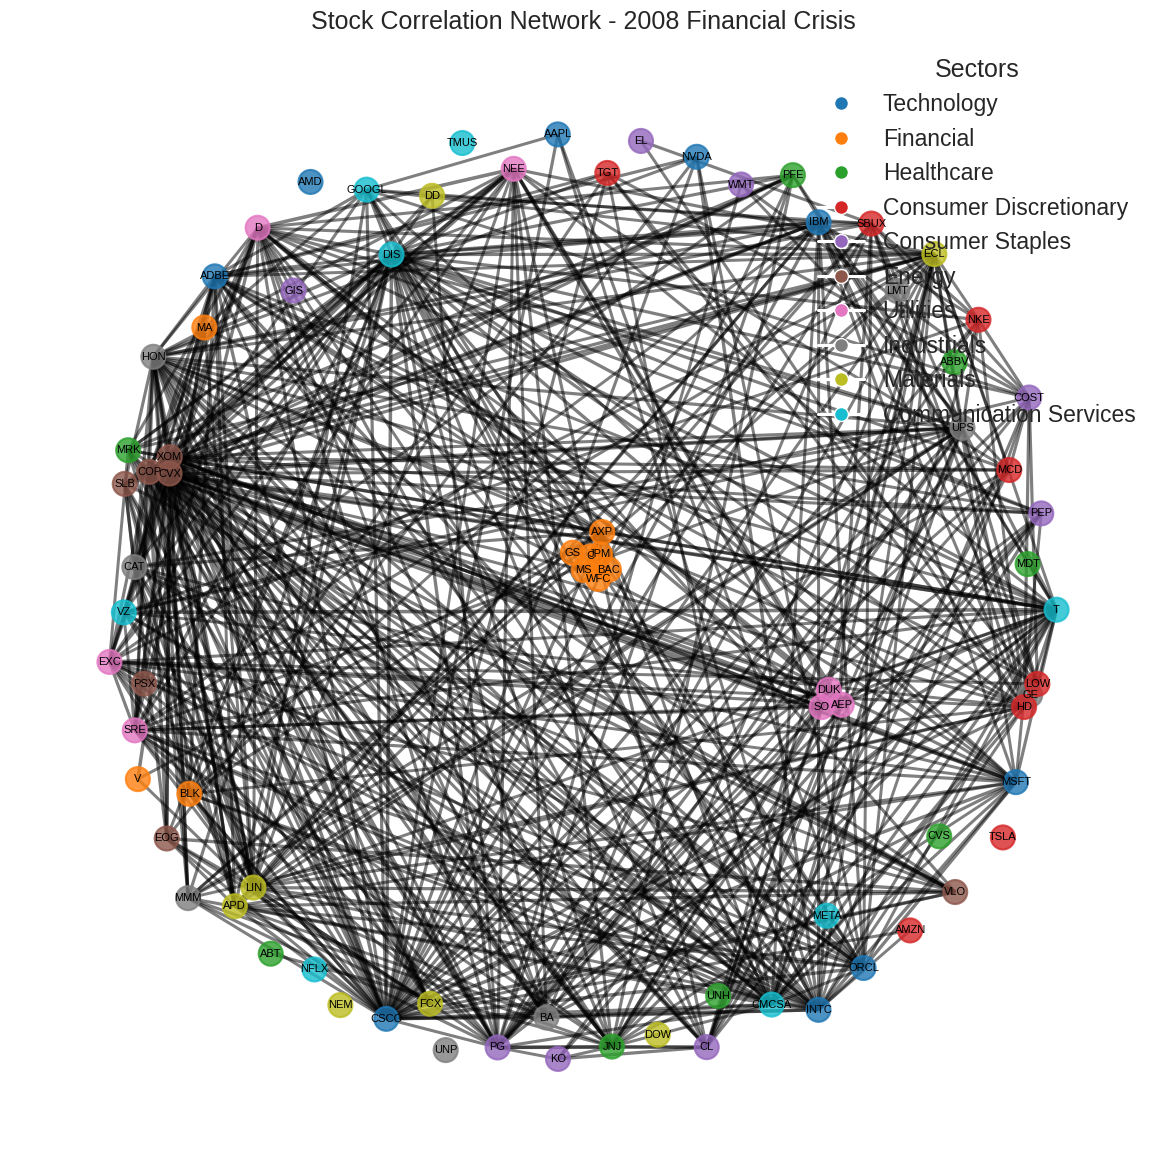

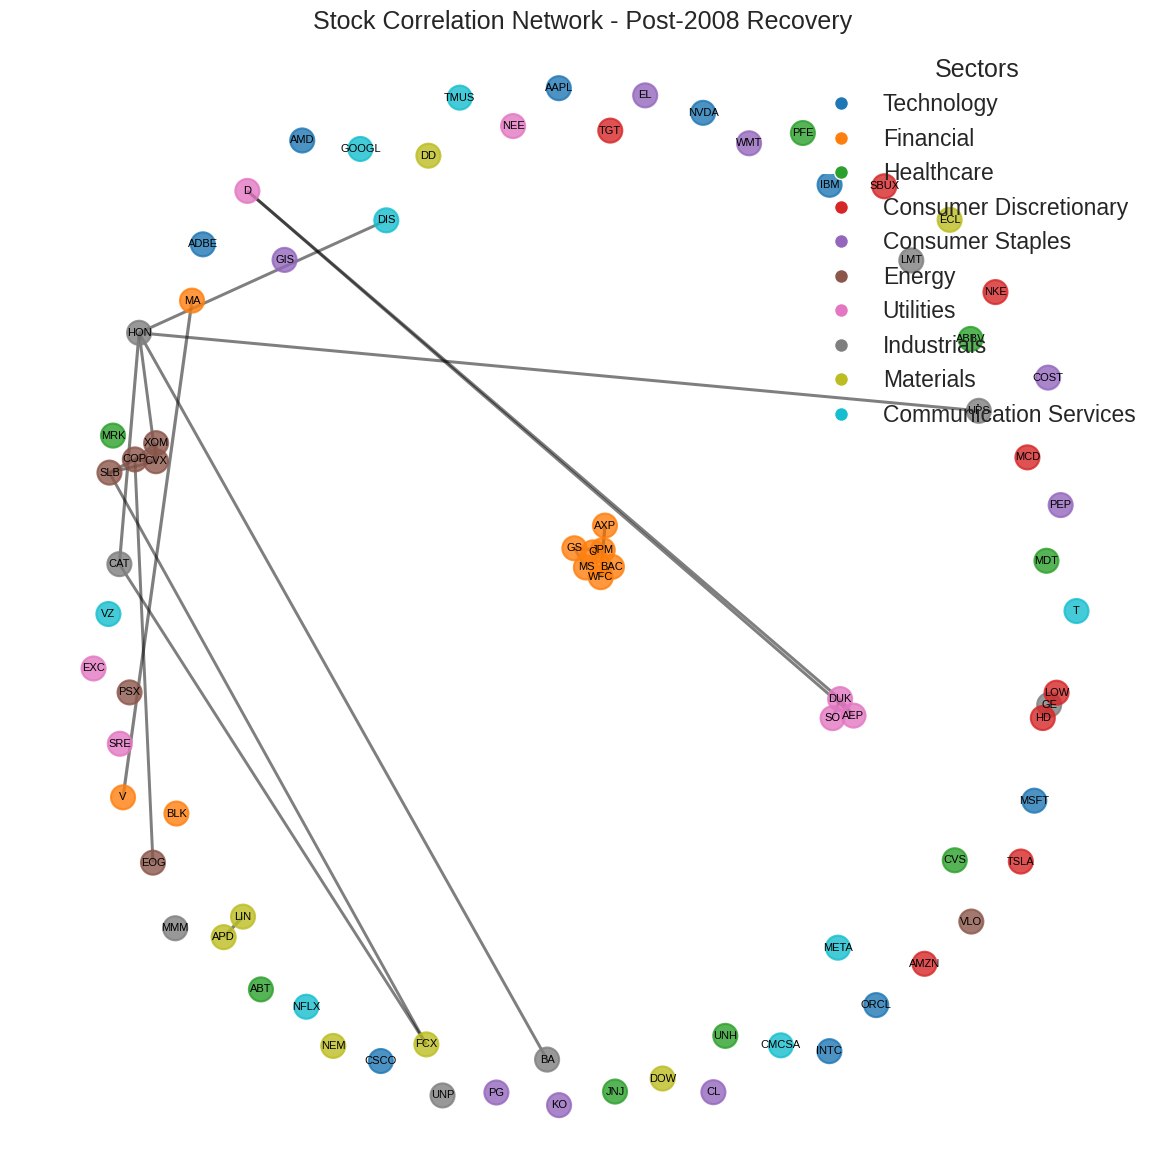

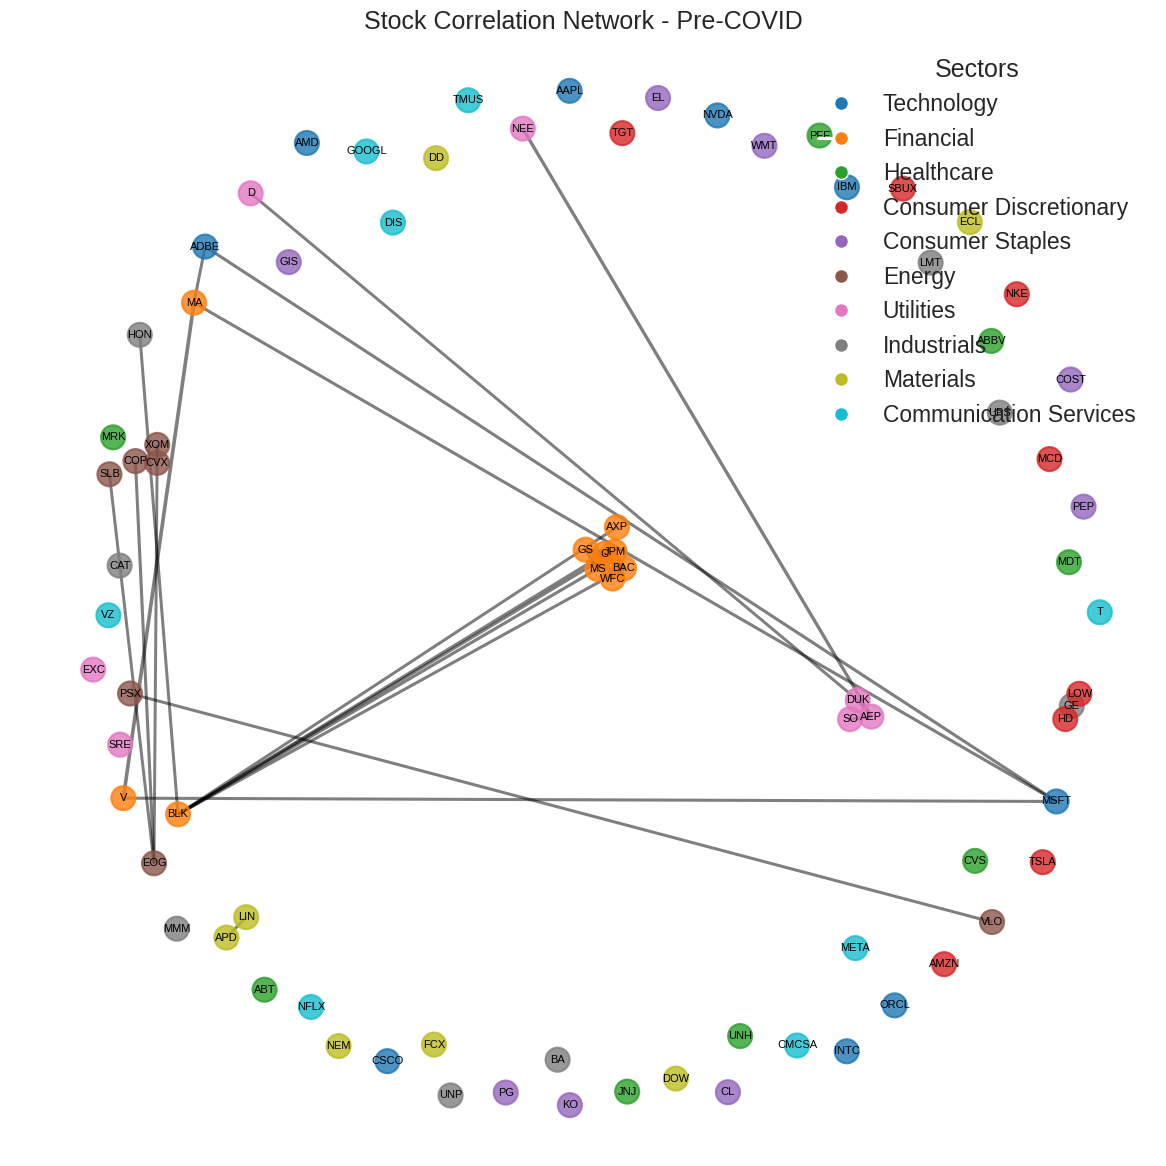

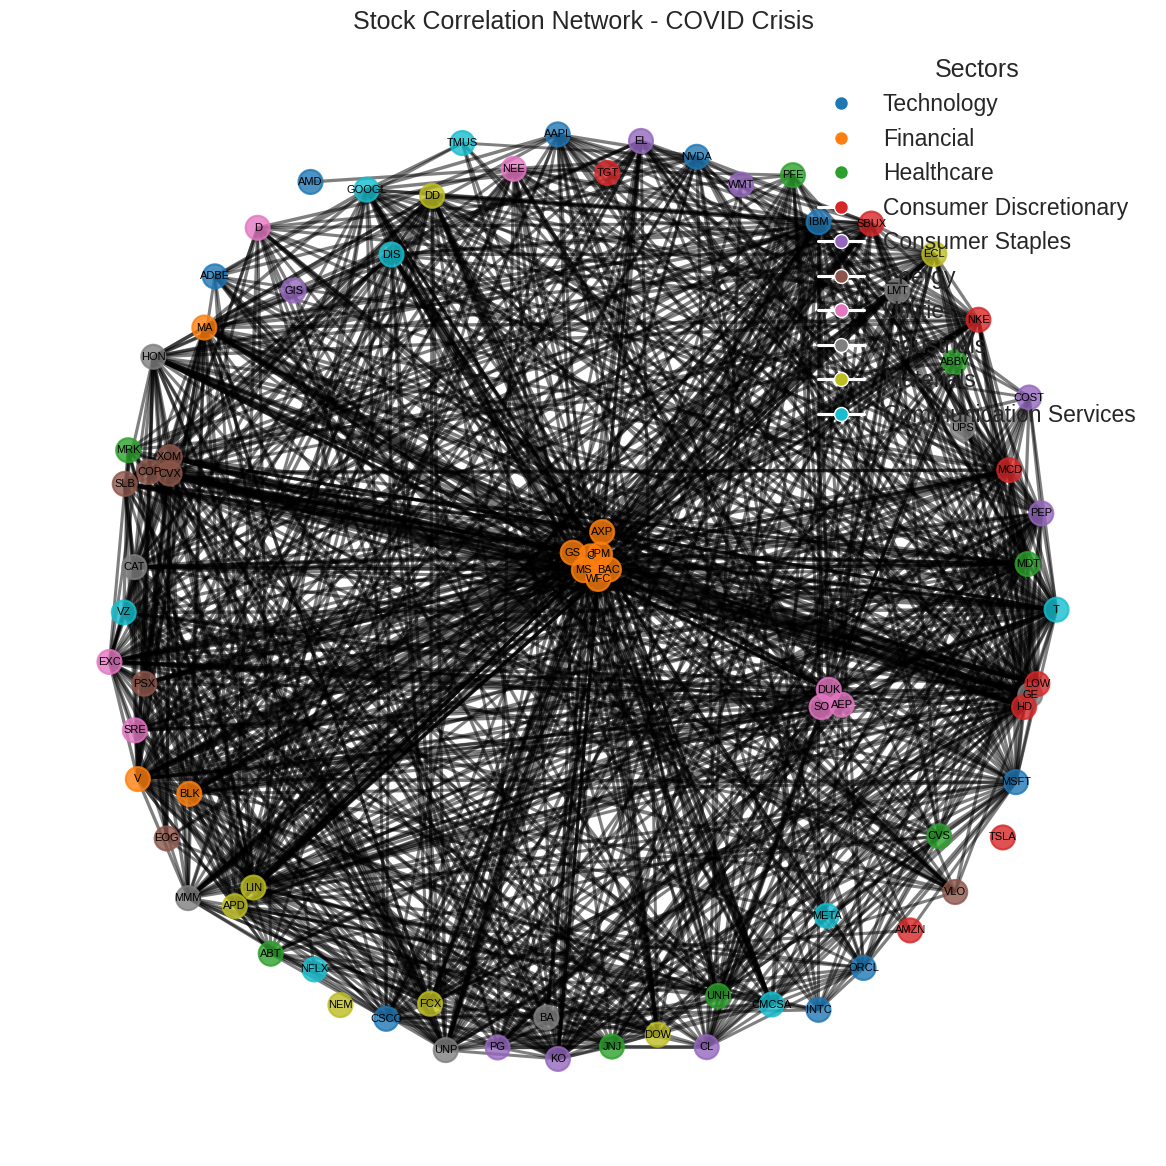

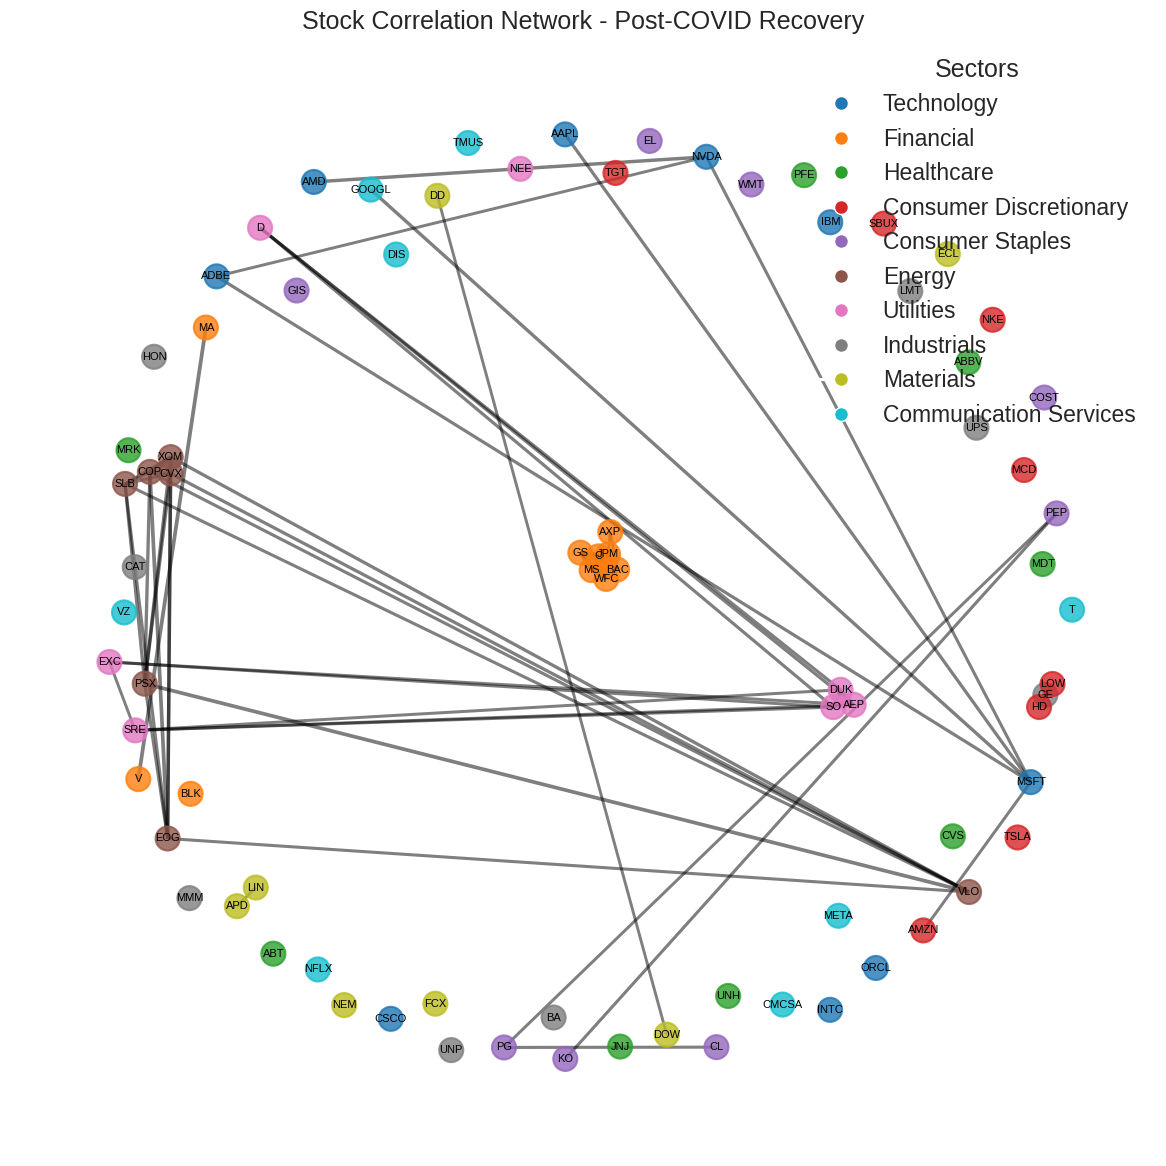

In [ ]:
# Visualize networks for each time period
# Create a consistent layout for all networks
base_layout = nx.spring_layout(networks['Pre-2008 Crisis'], seed=42)

# Visualize each network
for period_name, network in networks.items():
    visualize_network(network, f'Stock Correlation Network - {period_name}', layout=base_layout)
    plt.show()

### Interactive Network Visualization with Plotly
Let's create an interactive visualization using Plotly for better exploration.

In [ ]:
def create_interactive_network(G, title):
    """
    Create an interactive network visualization using Plotly.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph
    title : str
        Plot title
    """
    # Create layout
    pos = nx.spring_layout(G, seed=42)

    # Create edge trace
    edge_x = []
    edge_y = []
    edge_weights = []

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G[edge[0]][edge[1]]['weight'])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create node trace
    node_x = []
    node_y = []
    node_text = []
    node_sectors = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br>Sector: {G.nodes[node]['sector']}")
        node_sectors.append(G.nodes[node]['sector'])

    # Define colors for sectors
    sector_colors = {
        'Technology': '#1f77b4',
        'Financial': '#ff7f0e',
        'Healthcare': '#2ca02c',
        'Consumer Discretionary': '#d62728',
        'Consumer Staples': '#9467bd',
        'Energy': '#8c564b',
        'Utilities': '#e377c2',
        'Industrials': '#7f7f7f',
        'Materials': '#bcbd22',
        'Communication Services': '#17becf',
        'Unknown': '#000000'
    }

    node_colors = [sector_colors[sector] for sector in node_sectors]

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            color=node_colors,
            size=10,
            line=dict(width=2, color='white')
        )
    )

    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                 ))

    return fig

In [ ]:
# Create interactive visualization for the 2008 Financial Crisis period
fig = create_interactive_network(networks['2008 Financial Crisis'], 'Stock Correlation Network - 2008 Financial Crisis')
fig.show()

## Network Analysis
Now, let's analyze the network properties to gain insights into the market structure during different periods.

In [ ]:
def analyze_network(G):
    """
    Analyze network properties.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph

    Returns:
    --------
    dict
        Dictionary of network metrics
    """
    metrics = {}

    # Basic metrics
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)

    # Connected components
    components = list(nx.connected_components(G))
    metrics['num_components'] = len(components)

    if metrics['num_components'] > 0:
        largest_component = max(components, key=len)
        metrics['largest_component_size'] = len(largest_component)
        metrics['largest_component_ratio'] = len(largest_component) / metrics['num_nodes']
    else:
        metrics['largest_component_size'] = 0
        metrics['largest_component_ratio'] = 0

    # Centrality measures (only if there are edges)
    if metrics['num_edges'] > 0:
        # Degree centrality
        degree_centrality = nx.degree_centrality(G)
        metrics['avg_degree_centrality'] = sum(degree_centrality.values()) / len(degree_centrality)
        metrics['max_degree_centrality'] = max(degree_centrality.values())
        metrics['max_degree_node'] = max(degree_centrality.items(), key=lambda x: x[1])[0]

        # Betweenness centrality (only for connected graphs or components)
        if metrics['num_components'] == 1:
            betweenness_centrality = nx.betweenness_centrality(G)
            metrics['avg_betweenness_centrality'] = sum(betweenness_centrality.values()) / len(betweenness_centrality)
            metrics['max_betweenness_centrality'] = max(betweenness_centrality.values())
            metrics['max_betweenness_node'] = max(betweenness_centrality.items(), key=lambda x: x[1])[0]
    else:
        metrics['avg_degree_centrality'] = 0
        metrics['max_degree_centrality'] = 0
        metrics['max_degree_node'] = None

    return metrics

In [ ]:
# Analyze networks for each time period
network_metrics = {}
for period_name, network in networks.items():
    metrics = analyze_network(network)
    network_metrics[period_name] = metrics

    print(f"Period: {period_name}")
    print(f"  - Number of nodes: {metrics['num_nodes']}")
    print(f"  - Number of edges: {metrics['num_edges']}")
    print(f"  - Network density: {metrics['density']:.4f}")
    print(f"  - Number of connected components: {metrics['num_components']}")
    print(f"  - Largest component size: {metrics['largest_component_size']} ({metrics['largest_component_ratio']*100:.1f}% of nodes)")
    if metrics['max_degree_node']:
        print(f"  - Most central node: {metrics['max_degree_node']} (Degree centrality: {metrics['max_degree_centrality']:.4f})")
    print()

Period: Pre-2008 Crisis
  - Number of nodes: 80
  - Number of edges: 24
  - Network density: 0.0076
  - Number of connected components: 67
  - Largest component size: 7 (8.8% of nodes)
  - Most central node: C (Degree centrality: 0.0759)

Period: 2008 Financial Crisis
  - Number of nodes: 80
  - Number of edges: 537
  - Network density: 0.1699
  - Number of connected components: 16
  - Largest component size: 65 (81.2% of nodes)
  - Most central node: CSCO (Degree centrality: 0.5823)

Period: Post-2008 Recovery
  - Number of nodes: 80
  - Number of edges: 28
  - Network density: 0.0089
  - Number of connected components: 59
  - Largest component size: 11 (13.8% of nodes)
  - Most central node: HON (Degree centrality: 0.0633)

Period: Pre-COVID
  - Number of nodes: 80
  - Number of edges: 33
  - Network density: 0.0104
  - Number of connected components: 59
  - Largest component size: 9 (11.2% of nodes)
  - Most central node: BAC (Degree centrality: 0.0759)

Period: COVID Crisis
  - Num

### Compare Network Metrics Across Periods
Let's visualize how network metrics change across different time periods.

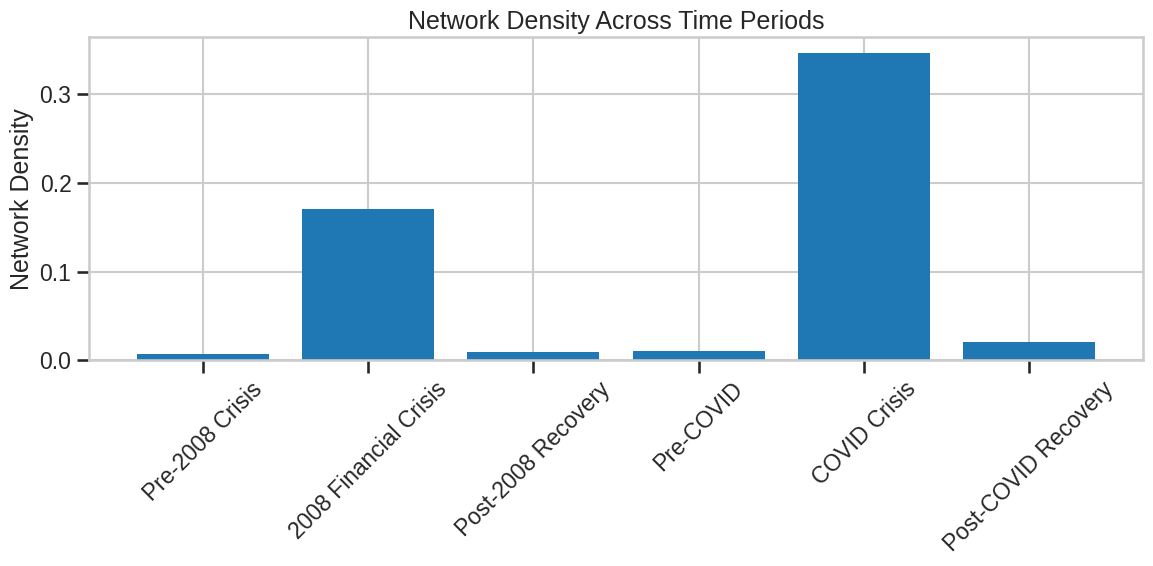

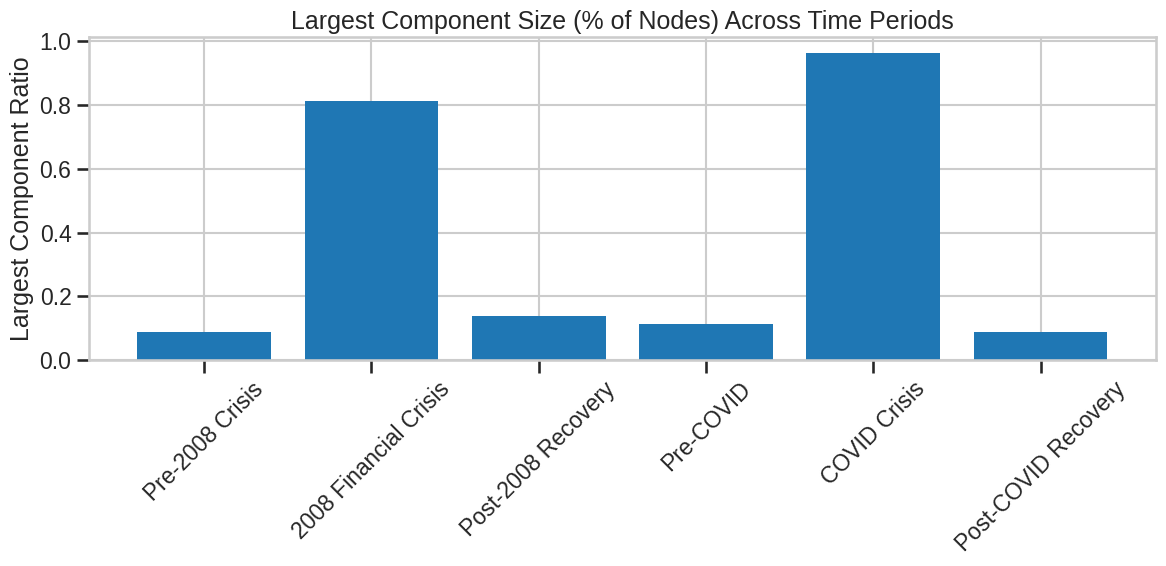

In [ ]:
# Create a DataFrame of network metrics
metrics_df = pd.DataFrame(network_metrics).T

# Plot network density
plt.figure(figsize=(12, 6))
plt.bar(metrics_df.index, metrics_df['density'])
plt.title('Network Density Across Time Periods')
plt.ylabel('Network Density')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot largest component ratio
plt.figure(figsize=(12, 6))
plt.bar(metrics_df.index, metrics_df['largest_component_ratio'])
plt.title('Largest Component Size (% of Nodes) Across Time Periods')
plt.ylabel('Largest Component Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion and Insights
Based on our analysis, we can draw several insights about how stock market correlations evolve over time:

1. **Crisis Periods**: During financial crises (2008 Financial Crisis and COVID-19 pandemic), we observe:
   - Higher network density, indicating stronger correlations across the market
   - Larger connected components, suggesting more uniform market behavior
   - Increased correlation within and across sectors

2. **Sector Behavior**:
   - Some sectors (like Energy and Financials) show consistently high internal correlations
   - Technology stocks show varying correlation patterns over time
   - Utilities and Consumer Staples often remain less correlated with other sectors

3. **Market Structure Evolution**:
   - The market network structure becomes more densely connected during periods of stress
   - Recovery periods show gradual fragmentation as correlations decrease
   - Certain stocks consistently appear as central nodes in the network

These findings support our initial hypotheses and provide visual evidence of how market correlations strengthen during downturns and diversify during stable periods. The network visualization approach offers a powerful way to understand market dynamics beyond traditional correlation matrices.

## Future Work

There are several ways this analysis could be extended:

1. **Incorporate More Data**:
   - Include more stocks or different asset classes (bonds, commodities, etc.)
   - Add macroeconomic indicators as nodes in the network
   - Extend the time period to cover more market cycles

2. **Advanced Network Analysis**:
   - Apply community detection algorithms to identify market clusters
   - Use dynamic network metrics to track evolution more precisely
   - Implement predictive models based on network features

3. **Interactive Visualization**:
   - Create a time-slider for exploring network evolution
   - Develop a dashboard for real-time monitoring of market correlations
   - Add more interactive features for exploring individual stocks

4. **Alternative Correlation Measures**:
   - Explore non-linear correlation measures
   - Implement time-frequency approaches like wavelet coherence
   - Consider tail dependencies for extreme market events